# Visualize small network example

In [4]:
from experiment_dir import set_cwd_project_root

set_cwd_project_root()

In [ ]:
from visualtorch.utils.layer_utils import SpacingDummyLayer, register_hook
from visualtorch.utils.utils import (
    Box,
    ColorWheel,
    self_multiply,
)


def _create_architecture(
    layers,
    x_off: int,
    img_height: int,
    max_right: int,
    type_ignore: list,
    index_ignore: list,
    min_xy: int,
    min_z: int,
    one_dim_orientation: str,
    scale_xy: float,
    max_xy: int,
    scale_z: float,
    max_z: int,
    draw_volume: bool,
    shade_step: int,
    spacing: int,
    color_map: dict,
    opacity: int,
    padding: int,
) -> tuple:
    boxes = []
    layer_types = []
    layer_y = []
    color_wheel = ColorWheel()
    current_z = padding

    for index, key in enumerate(layers):
        layer = layers[key]["module"]
        shape = layers[key]["output_shape"]
        # Do no render the SpacingDummyLayer, just increase the pointer
        if type(layer) == SpacingDummyLayer:
            current_z += layer.spacing
            continue

        # Ignore layers that the use has opted out to
        if type(layer) in type_ignore or index in index_ignore:
            continue

        layer_type = type(layer)

        if layer_type not in layer_types:
            layer_types.append(layer_type)

        x = min_xy
        y = min_xy
        z = min_z

        shape = shape[1:]  # drop batch size

        if len(shape) == 1:
            if one_dim_orientation in ["x", "y", "z"]:
                shape = (1,) * "cxyz".index(one_dim_orientation) + shape
            else:
                error_msg = f"unsupported orientation: {one_dim_orientation}"
                raise ValueError(error_msg)

        shape = shape + (1,) * (4 - len(shape))  # expand 4D.

        x = min(max(shape[1] * scale_xy, x), max_xy)
        z = min(max(shape[2] * scale_xy, z), max_xy)  # height becomes depth!
        y = min(max(int(self_multiply(shape[0:1] + shape[3:]) * scale_z), y), max_z)

        box = Box()

        box.de = 0
        if draw_volume:
            box.de = int(x / 3)

        if x_off == -1:
            x_off = int(box.de / 2)

        # top left coordinate
        box.x1 = current_z - int(box.de / 2)
        box.y1 = box.de

        # bottom right coordinate
        box.x2 = box.x1 + z
        box.y2 = box.y1 + y

        box.set_fill(
            color_map.get(layer_type, {}).get(
                "fill",
                color_wheel.get_color(layer_type),
            ),
            opacity,
        )
        box.outline = color_map.get(layer_type, {}).get("outline", "black")
        color_map[layer_type] = {"fill": box.fill, "outline": box.outline}

        box.shade = shade_step
        boxes.append(box)
        layer_y.append(box.y2 - (box.y1 - box.de))

        # Update image bounds
        hh = box.y2 - (box.y1 - box.de)
        if hh > img_height:
            img_height = hh

        if box.x2 + box.de > max_right:
            max_right = box.x2 + box.de

        current_z += z + spacing

    return layer_y, layer_types, boxes, x_off, img_height, max_right


import visualtorch

visualtorch.layered._create_architecture = _create_architecture

Loading QuickDrawDataset: 3it [00:00, 401.56it/s]
c:\Users\matth\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Tokenizing dataset: 100%|██████████| 3/3 [00:00<00:00, 944.66it/s]


No checkpoint found, starting fresh training.
torch.Size([128, 199])


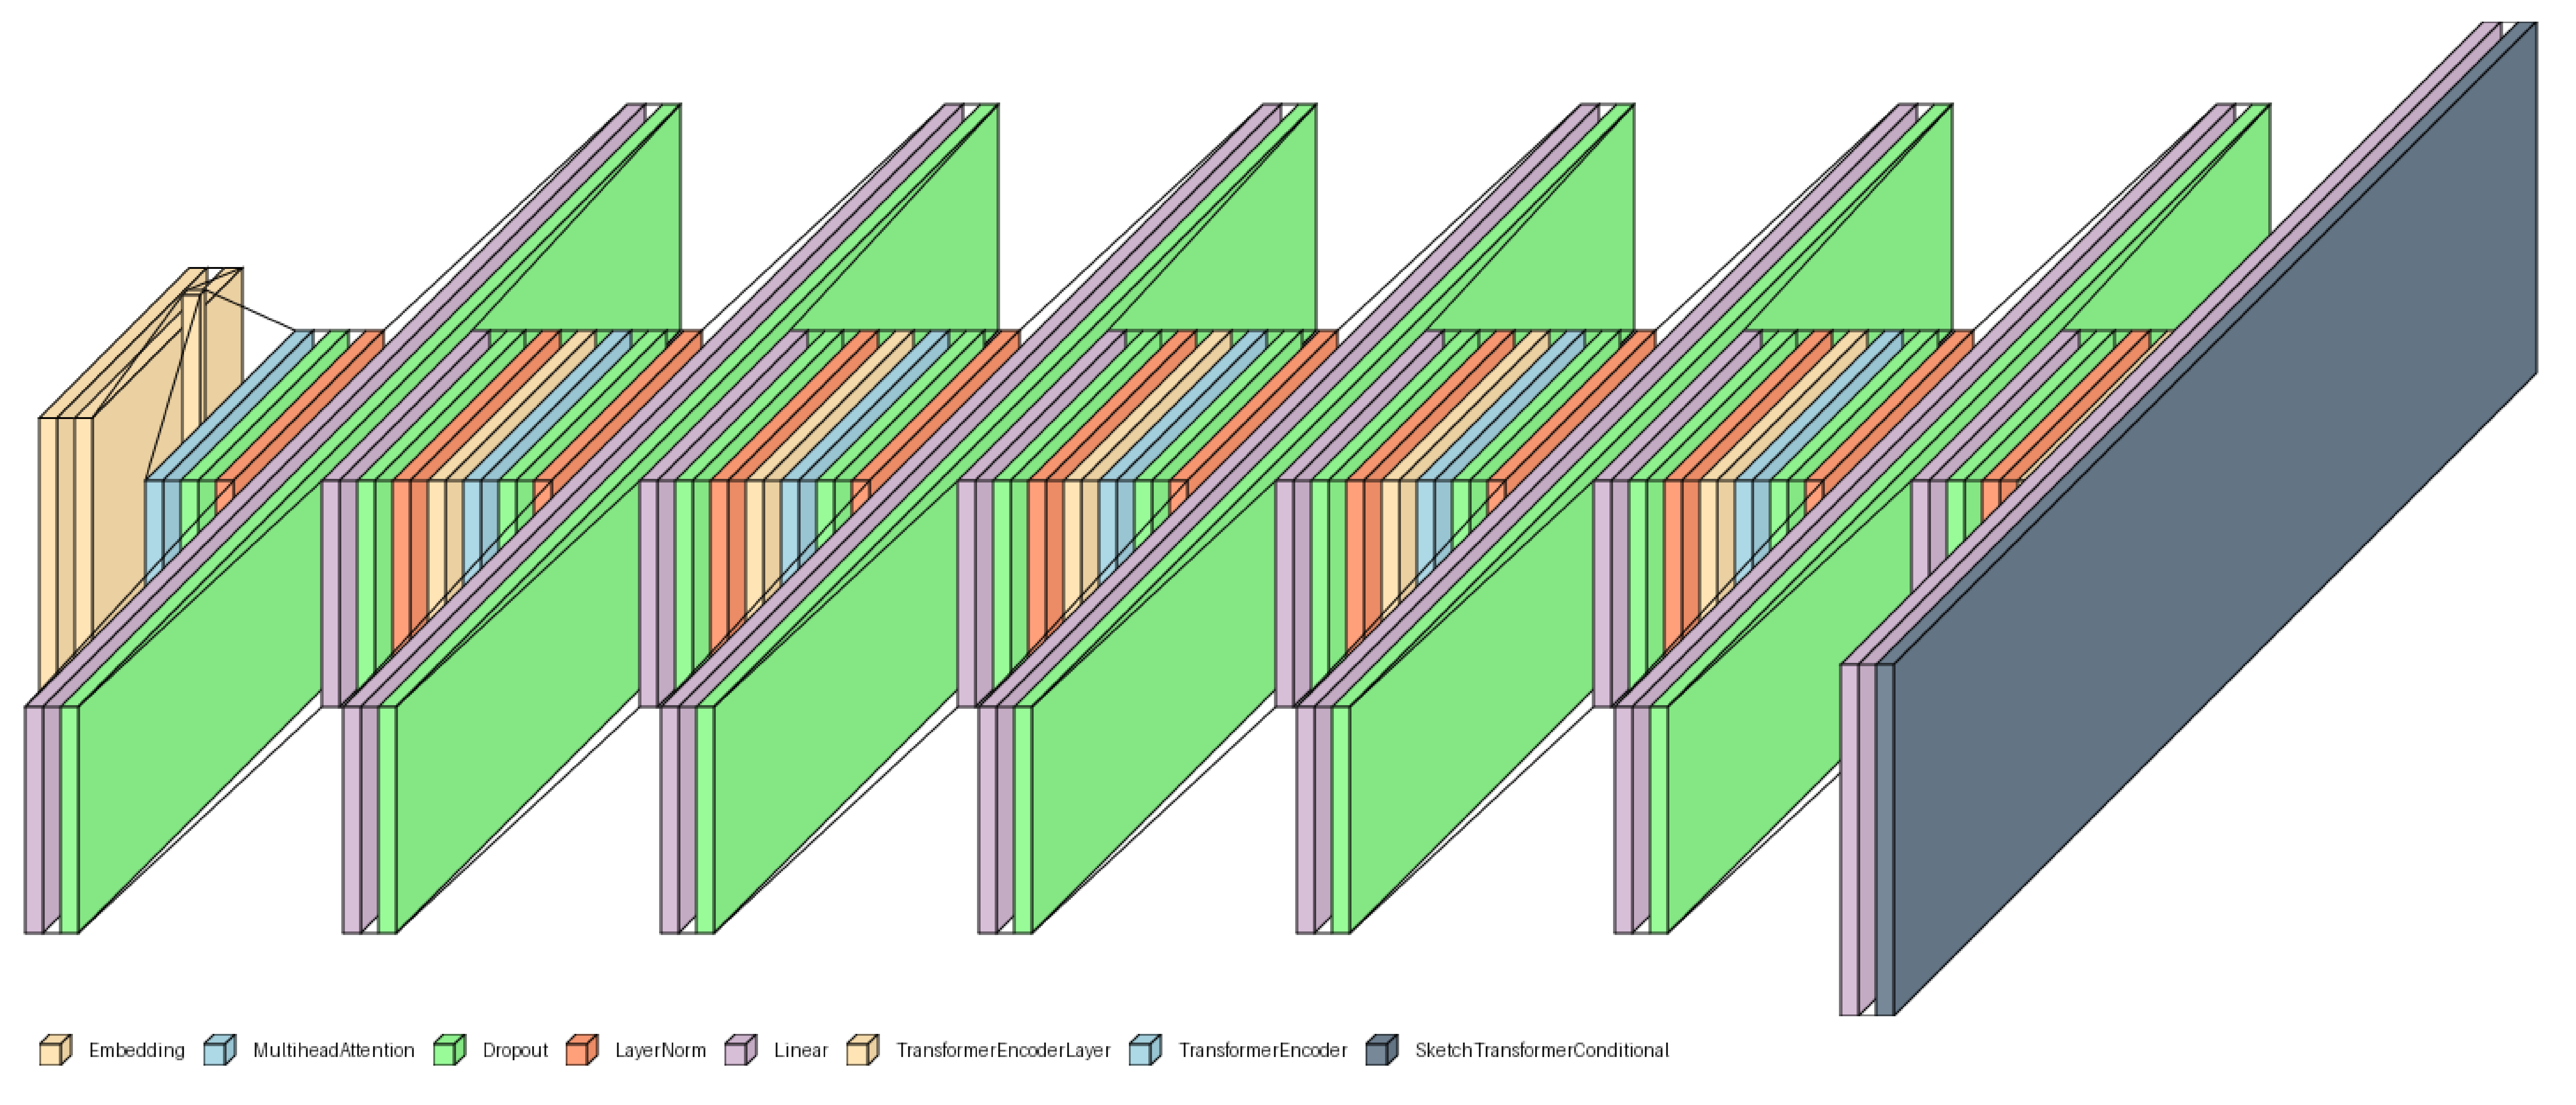

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import defaultdict

from dataset import QuickDrawDataset
from sketch_tokenizers import DeltaPenPositionTokenizer
from models import SketchTransformerConditional
from runner import SketchTrainer, sample

label_names = ["bird", "crab", "guitar"]
dataset = QuickDrawDataset(label_names=label_names, download=True)
tokenizer = DeltaPenPositionTokenizer(bins=16)

model = SketchTransformerConditional(
    vocab_size=len(tokenizer.vocab),
    d_model=256,
    nhead=8,
    num_layers=6,
    max_len=200,
    num_classes=len(label_names),
)

training_config = {
    "batch_size": 128,
    "num_epochs": 15,
    "learning_rate": 1e-4,
    "log_dir": "logs/example_drawing",
}

trainer = SketchTrainer(
    model=model, dataset=dataset, tokenizer=tokenizer, training_config=training_config
)


class ModelForVisual(nn.Module):
    def __init__(self, model, num_classes):
        super().__init__()
        self.model = model
        self.num_classes = num_classes

    def forward(self, input_ids):
        # visualtorch passes a FloatTensor → must cast
        input_ids = input_ids.long()
        batch, seq_len = input_ids.shape

        # dummy class labels (choose class 0)
        class_labels = torch.zeros(batch, dtype=torch.long, device=input_ids.device)

        # forward through actual model
        return self.model(input_ids, class_labels)


wrapped = ModelForVisual(model, num_classes=model.num_classes).cpu()
input_ids, _, _ = next(iter(trainer.train_loader))
input_shape = input_ids.shape

print(input_shape)

color_map: dict = defaultdict(dict)
color_map[SketchTransformerConditional]["fill"] = "LightSlateGray"  # Light Slate Gray

img = visualtorch.layered_view(
    wrapped,
    input_shape=input_shape,
    legend=True,
    scale_z=1.0,
    color_map=color_map,
)

plt.figure(figsize=(12, 12), dpi=600)
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()